# 05 2d Classical Ising Model Monte Carlo

In [162]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
try: plt.style.use('./mc_notebook.mplstyle')
except: pass
from IPython.display import display

## Ising Model of Ferromagnatism

Measuring energies in units where $J=k_{\rm B} = 1$ we can write the Ising model Hamiltonian:

\begin{equation}
H = - \sum_{\langle i,j\rangle } \sigma_i \sigma_j
\end{equation}

where $\sigma_i = \pm 1$ and $\langle i,j \rangle$ means that sites $i$ and $j$ are nearest neighbors.  Let's consider a $N = L \times L$ square lattice in $d=2$ with periodic boundary conditions.  This is equivalent to wrapping our lattice onto the surface of a torus.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/Torus_from_rectangle.gif" width=400px>

In two dimensions, our *spin* array $\sigma_i$ can be written as a matrix:

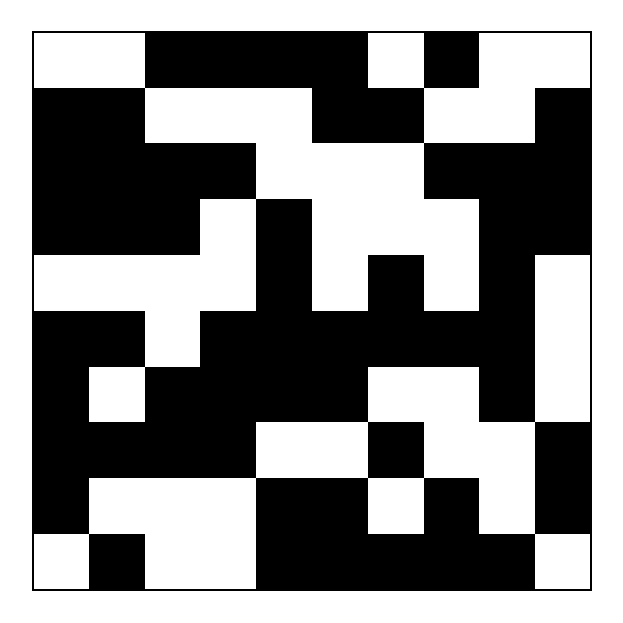

In [121]:
def initialize_config(L):
    '''Initialize a random spin configuration'''

    σ = np.ones([L,L],dtype=int)
    σ[np.random.random([L,L])<=0.5] = -1
    return σ


L = 10
σ = initialize_config(L)

# visualize
plt.matshow(σ, cmap='gray', extent=[0,9,0,9]);
plt.xticks([]);
plt.yticks([]);

In terms of this matrix, the energy can be written as:

\begin{equation}
E(\sigma) = - \frac{1}{2}\sum_{i=0}^{L-1} \sum_{j=0}^{L-1} \sigma[i,j]\left(\sigma[i+1,j] + \sigma[i-1,j] + \sigma[i,j+1] + \sigma[i,j-1]\right)
\end{equation}

How do we deal with the periodic boundary conditions?

In [122]:
p1 = np.arange(1,L+1)
p1[-1] = 0
m1 = np.arange(-1,L-1)
m1[0] = L-1

display(p1)
display(m1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

array([9, 0, 1, 2, 3, 4, 5, 6, 7, 8])

### Thermodynamic Properties: Energy and Magnetization per Spin

In [123]:
def get_props(σ):
    '''The energy E and magnetization M per spin for a microstate of the 2d Ising model.'''
    E,M = 0,0
    Lx = σ.shape[1]
    Ly = σ.shape[0]
    
    for i in range(Lx):
        for j in range(Ly):
            M += σ[i,j]
            E -= 0.5*σ[i,j]*(σ[p1[i],j] + σ[m1[i],j] + σ[i,p1[j]] + σ[i,m1[j]])
    return E/(Lx*Ly),M/(Lx*Ly)

In [124]:
get_props(σ)

(-0.04, -0.14)

## Monte Carlo Update

We need to sample the Boltzmann probability:

\begin{equation}
\pi(\sigma) = \frac{\mathrm{e}^{-\beta E(\sigma)}}{\mathcal{Z}}
\end{equation}

which can be done via Metropolis Monte Carlo by constructing a Markov chain with update acceptance probabilities:

\begin{equation}
p(\sigma \to \sigma') = \text{min}\left[1,\frac{\pi(\sigma')\mathcal{A}(\sigma' \to \sigma)}{\pi(\sigma)\mathcal{A}(\sigma \to \sigma')}\right].
\end{equation}

Here, the easiest update consists of flipping an individual spin and thus the *a priori* update probability is $\mathcal{A} = 1/N$ for all updates so it cancels out of the probability.   

Next, we need to determine the change in energy as:

\begin{equation}
\frac{\pi(\sigma')}{\pi(\sigma)} = \frac{\mathrm{e}^{-E(\sigma')/T}}{\mathrm{e}^{-E(\sigma)/T}} = \mathrm{e}^{-\Delta E/T}
\end{equation}

where $\Delta E = E(\sigma') - E(\sigma)$.

**Note: the partition function has cancelled out of the probability!**


Suppose we flip the spin with index $k,\ell$, then: $\sigma'[k,\ell] = -\sigma[k,\ell]$ and we can write:

\begin{equation}
\Delta E = 2\sigma[k,\ell]\left(\sigma[k+1,\ell] + \sigma[k-1,\ell] + \sigma[k,\ell+1] + \sigma[k,\ell-1]\right).
\end{equation}

and 

\begin{equation}
\Delta M = 2 \sigma[k,\ell]
\end{equation}

and thus the acceptance probability for the move will be:

\begin{equation}
p(\sigma \to \sigma') = P_{\rm acc} = \mathrm{e}^{-\Delta E/T}.
\end{equation}

Each Monte Carlo update thus consists of:

1. Select a random spin to flip with equal probability
2. Calculate $\Delta E$
3. Generate a uniform random number $r \in \mathcal{U}_{[0,1)}$
4. Perform the Metropolis test
    - If $r < \mathrm{e}^{-\Delta E/T}$: accept the move
    - Otherwise: do nothing
5. Measure the magnetization

A Monte Carlo **step** consists of $N=L^2$ updates.

In [125]:
def monte_carlo_step(σ,T):
    '''Perform a Monte Carlo step.'''
    
    # get the current magnetization
    M = np.sum(σ)
    
    # attempt L^2 spin flips
    for update in range(σ.size):
        
        # get the random spin
        k = np.random.randint(0,σ.shape[0])
        ℓ = np.random.randint(0,σ.shape[1])
        
        # calculate the change in energy
        ΔE = 2*σ[k,ℓ]*(σ[p1[k],ℓ] + σ[m1[k],ℓ] + σ[k,p1[ℓ]] + σ[k,m1[ℓ]])
        
        # perform the Metropolis test
        if np.random.random() <= np.exp(-ΔE/T):
            σ[k,ℓ] *= -1

            # Update the magnetization
            M += 2*σ[k,ℓ]
    
    return M

### Testing it out

(-0.08, 0.06)

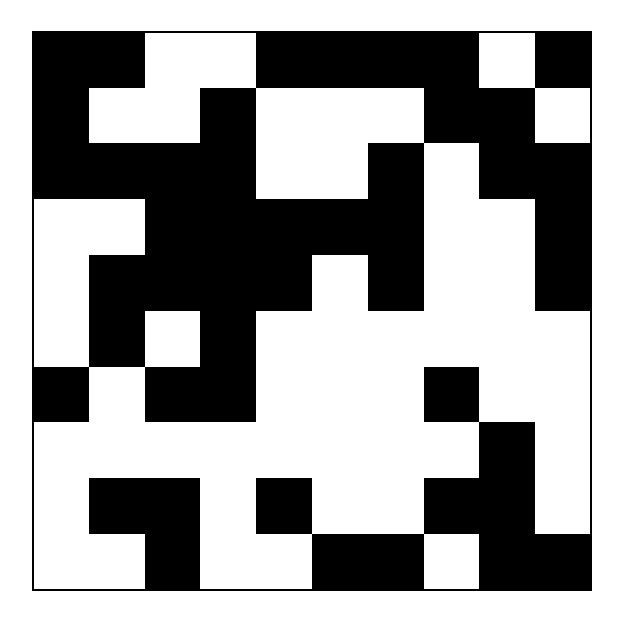

In [126]:
# initialize 
σ = initialize_config(L)

# visualize
plt.matshow(σ, cmap='gray', extent=[0,9,0,9]);
plt.xticks([]);
plt.yticks([]);
get_props(σ)

(-1.28, 0.22)

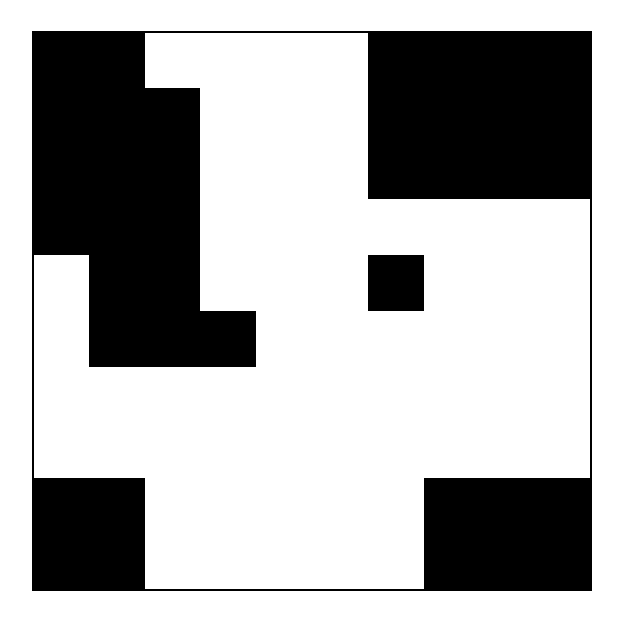

In [130]:
# update
monte_carlo_step(σ,1.0)

# visualize
plt.matshow(σ, cmap='gray', extent=[0,9,0,9]);
plt.xticks([]);
plt.yticks([]);
get_props(σ)

### Monte Carlo Simulation

A simulation consists of performing a large number of Monte Carlo steps at each temperature starting from some random initial configuration.

In [324]:
# temperatures to consider
T = np.arange(0.2,2.5,0.25)

# number of Monte Carlo steps we will perform
num_steps = 2**18

# magnetization for each temperature
M = np.zeros([num_steps,T.size])

In [325]:
%%time
# initialize
L = 4
σ = initialize_config(L)

# create PBC lookup tables
p1 = np.arange(1,L+1)
p1[-1] = 0
m1 = np.arange(-1,L-1)
m1[0] - L-1

# Loop over temperatures from high to low
for iT,cT in enumerate(T[::-1]):
    m = T.size - 1 - iT
    
    # initialize the magnetization
    M[0,m] = np.sum(σ)/L**2
    
    # Perform the Monte Carlo steps
    for step in range(1,num_steps):
        M[step,m] = monte_carlo_step(σ,cT)/L**2

CPU times: user 9.4 s, sys: 87.2 ms, total: 9.49 s
Wall time: 10.8 s


### Investigate the raw data

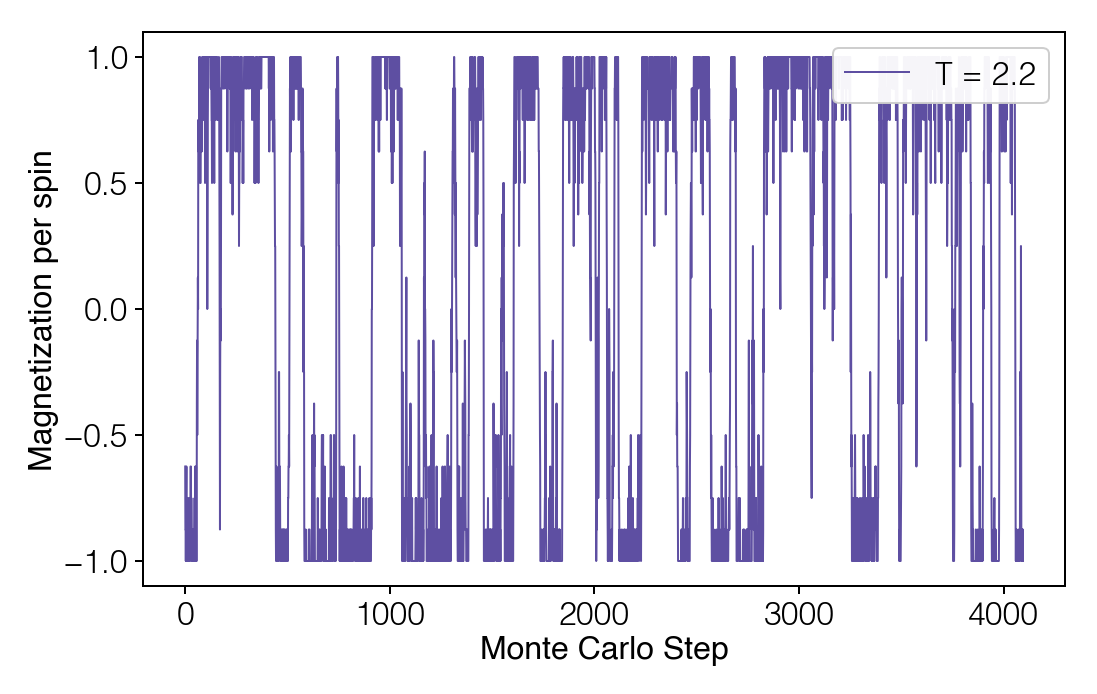

In [327]:
iT = -2
plt.plot(M[:,iT],'-', label='T = %3.1f' %T[iT])
plt.legend(loc='upper right', frameon=True, framealpha=0.95)
plt.xlabel('Monte Carlo Step')
plt.ylabel('Magnetization per spin');

### Analyzing the results

We want to compute the average value of the magnetization at each temperature along with its standard error, but we need to skip some number of initial measurements as the system takes some *time* to equilibrate.

In [328]:
skip = int(0.2*M.shape[0])
m = np.average(M[skip:],axis=0)
Δm = np.std(M[skip:],axis=0)/np.sqrt(num_steps-skip)

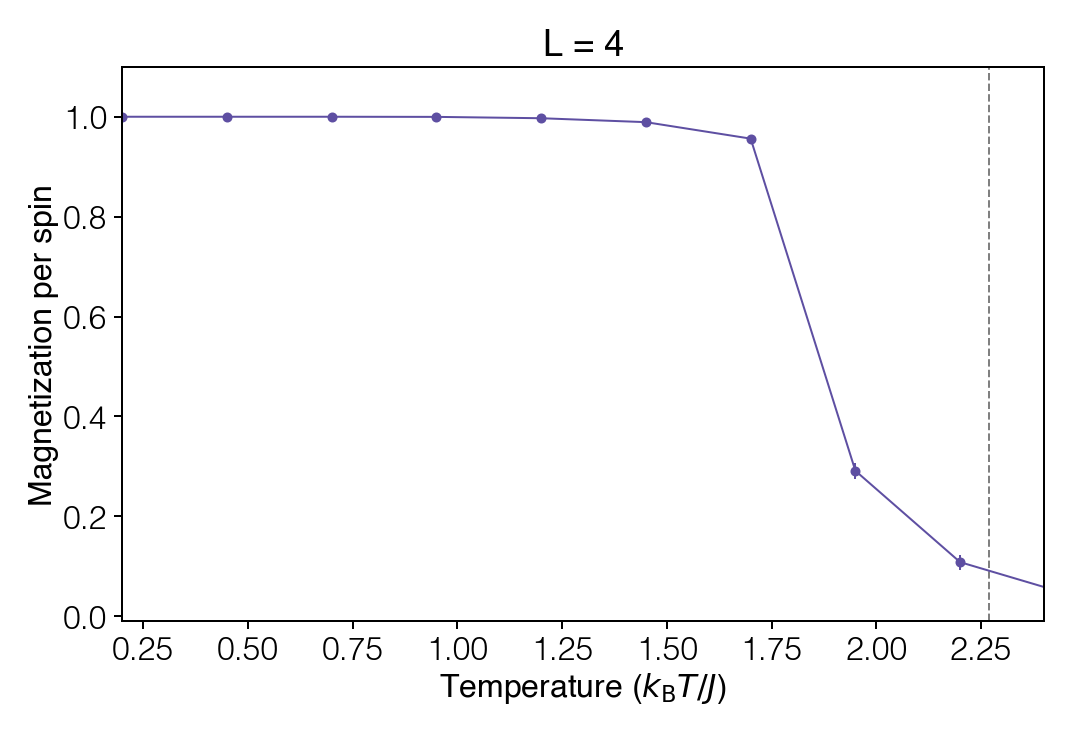

In [329]:
plt.errorbar(T,np.abs(m),yerr=Δm, linewidth=1, marker='o', markersize=4, elinewidth=1, capsize=0)
plt.axvline(x=2.0/np.log(1.0+np.sqrt(2.0)), linewidth=1, color='gray', linestyle='--')
plt.xlim(0.2,2.4)
plt.ylim(-0.01,1.1)
plt.xlabel(r'Temperature ($k_{\rm B}T/J$)')
plt.ylabel('Magnetization per spin')
plt.title("L = 4");

These error bars look **way** too small!  Need to perform a binning analysis!

In [330]:
def get_binned_error(mc_data):
    '''Get the standard error in mc_data and return neighbor averaged data.'''
    N_bins = mc_data.size
    Δ = np.std(mc_data)/np.sqrt(N_bins)
    
    start_bin = N_bins % 2
    binned_mc_data = 0.5*(mc_data[start_bin::2]+mc_data[start_bin+1::2])
   
    return Δ,binned_mc_data

In [331]:
# number of possible binning levels
num_levels = np.int(np.log2(M[skip:,0].size/4))+1

# compute the error at each bin level for each temperature
Δm = np.zeros([len(T),num_levels])

for iT,cT in enumerate(T):
    
    binned_mc_data = M[:,iT]
    for n in range(num_levels):
        Δₙ,binned_mc_data = get_binned_error(binned_mc_data)
        Δm[iT,n] = Δₙ

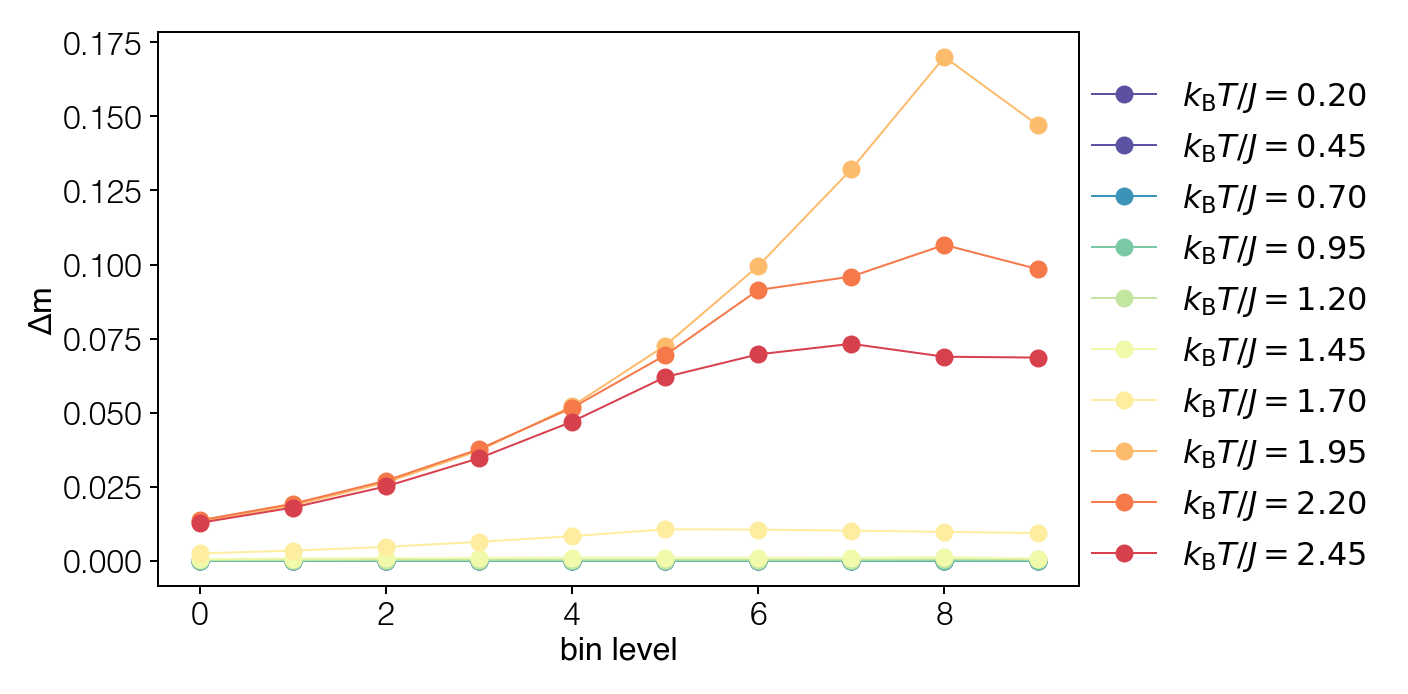

In [332]:
for iT,cT in enumerate(T):
    plt.plot(np.abs(Δm[iT]),'-o', linewidth=1, markersize=8, label='$k_{\mathrm{B}}T/J = %4.2f$'%cT)
    plt.xlabel('bin level')
    plt.ylabel('Δm');
    plt.legend(ncol=1, loc=(1,0))

### Replot with improved binned error bars

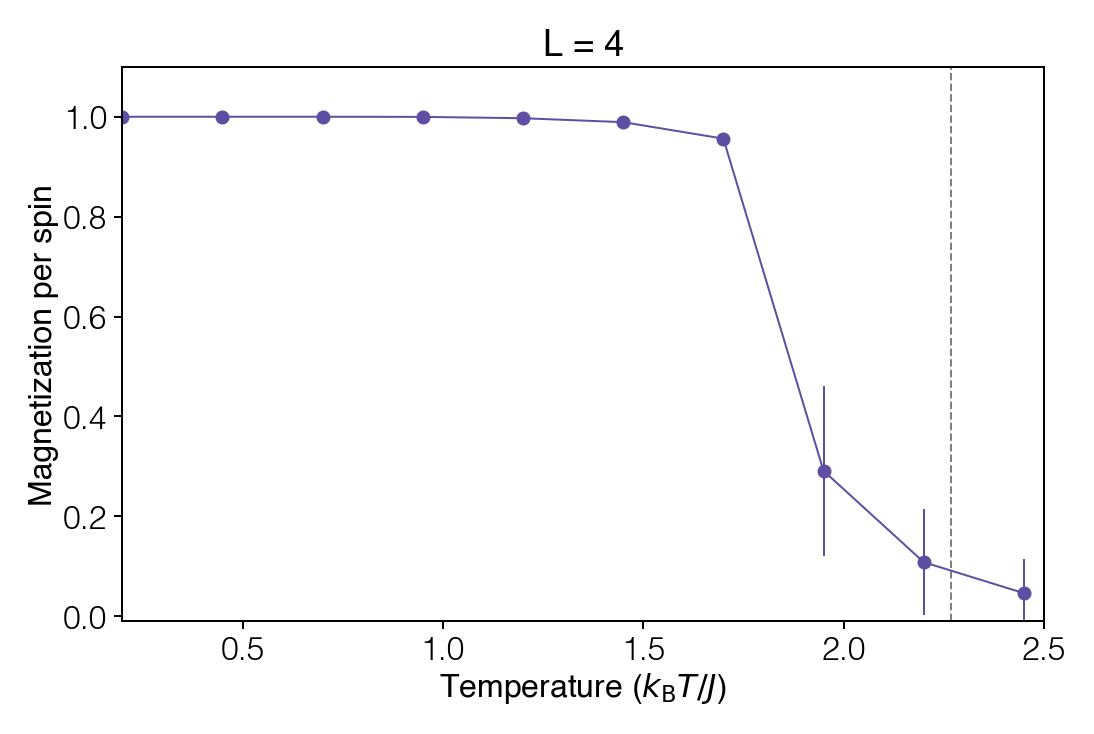

In [333]:
plt.errorbar(T,np.abs(m),yerr=Δm[:,-2], linewidth=1, marker='o', markersize=6, elinewidth=1, capsize=0)
plt.axvline(x=2.0/np.log(1.0+np.sqrt(2.0)), linewidth=1, color='gray', linestyle='--')
plt.xlim(0.2,2.5)
plt.ylim(-0.01,1.1)
plt.xlabel(r'Temperature ($k_{\rm B}T/J$)')
plt.ylabel('Magnetization per spin')
plt.title("L = 4");

## Load some data for a *much* longer run and $L=32$ from disk and compare with the exact Onsager solution

\begin{equation}
m=\left[1-\left(\sinh \frac{2J}{k_{\rm B}T}\right)^{-4}\right]^{\frac {1}{8}}
\end{equation}

In [286]:
def magnetization_exact_(T):
    '''We use units where J/k_B = 1.'''
    Tc = 2.0/np.log(1.0+np.sqrt(2.0))
    if T < Tc:
        return (1.0 - np.sinh(2.0/T)**(-4))**(1.0/8)
    else:
        return 0.0
magnetization_exact = np.vectorize(magnetization_exact_)

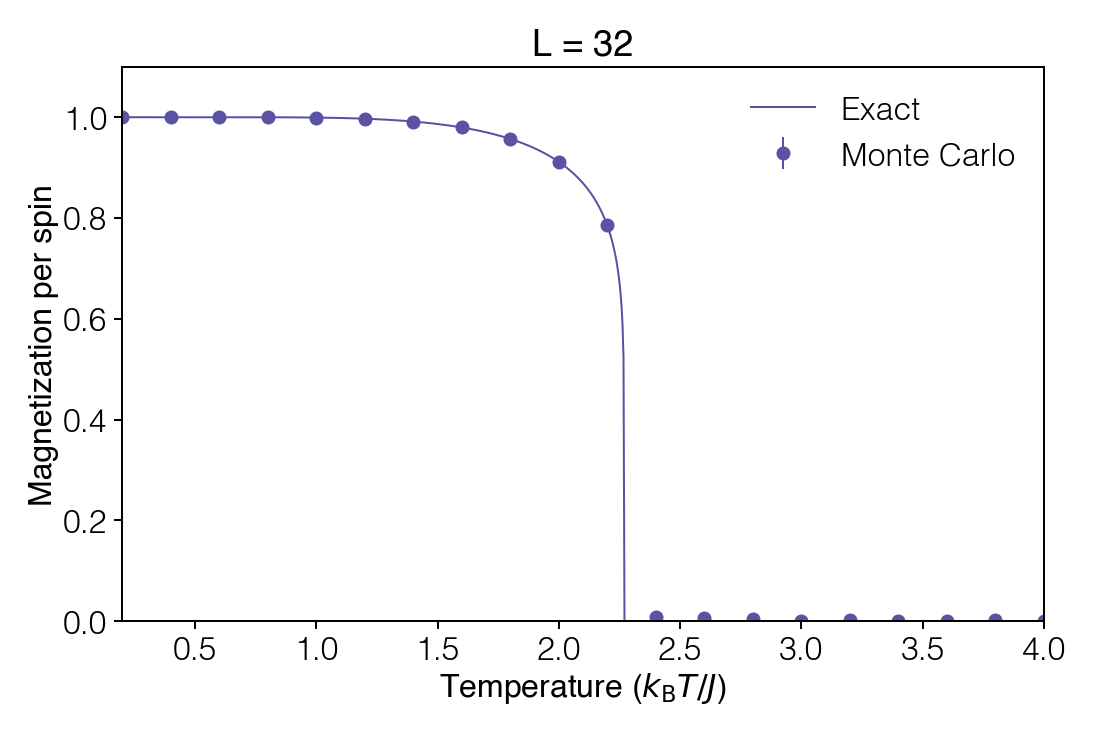

In [287]:
data = np.loadtxt('Ising_magnetization_032.dat')
lT = np.linspace(0.01,4,1000)
lL = 32

plt.plot(lT,magnetization_exact(lT),'-', linewidth=1, label='Exact')
plt.errorbar(data[:,0],np.abs(data[:,5])/lL**2,yerr=data[:,6]/lL**2, linewidth=1, marker='o', 
             markersize=6, elinewidth=1, label='Monte Carlo', linestyle='None')
plt.xlim(0.2,4)
plt.ylim(0,1.1)
plt.xlabel(r'Temperature ($k_{\rm B}T/J$)')
plt.ylabel('Magnetization per spin')
plt.title("L = 32")

plt.legend()

<!-- 
hlabel = 'm(T = %4.2f)' % T[0]
header = '%23s' % hlabel
for cT in T[1:]:
    hlabel = 'm(T = %4.2f)' % cT
    header += '%24s ' % hlabel
    
np.savetxt('Ising_magnetization_004.dat.gz',M, fmt='%24.16E', header=header)
M = np.loadtxt('Ising_magnetization_004.dat.gz')
-->